# dHybridR Example Notebook

#### Here we provide an example of what a typical analysis notebook will look like when computing velocity space signatures and generating MLA algo data will look like

In [1]:
import lib.loadfunctions as lf 
import lib.analysisfunctions as af
import lib.plotfunctions as pf
import lib.savefunctions as svf
import lib.sanityfunctions as sanf
import lib.fieldtransformfunctions as ftf

import os
import math
import numpy as np

In [2]:
#block to reload modules. Call this block after editing libraries
import importlib
importlib.reload(lf)
importlib.reload(af)
importlib.reload(pf)
importlib.reload(svf)
importlib.reload(sanf)
importlib.reload(ftf)

<module 'lib.fieldtransformfunctions' from '/Users/collbrown/Documents/OneDrive - University of Iowa/Research/DHybridR/analysistools/dHybridRAnalysis/lib/fieldtransformfunctions.py'>

### Load data

In [3]:
#variables related to loading
path = "run0/"
path_fields = "run0/"
path_particles = "run0/Output/Raw/Sp01/raw_sp01_{:08d}.h5"
numframe = 1000


In [4]:
#load fields
dfields = lf.field_loader(path=path_fields,num=numframe)

#load particle data
dparticles = lf.readParticlesPosandVelocityOnly(path_particles, numframe)

#load flow data
dflow = lf.flow_loader(path=path,num=numframe)

### Plot fields, particle dist function, and flow
#### used as a sanity check on the data

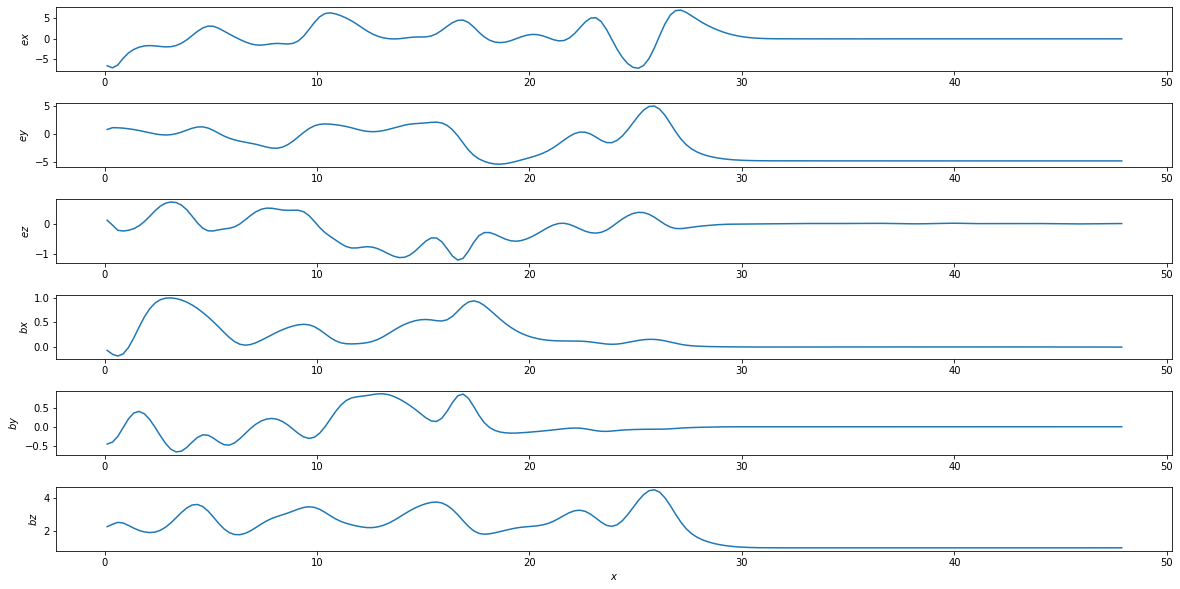

In [5]:
pf.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

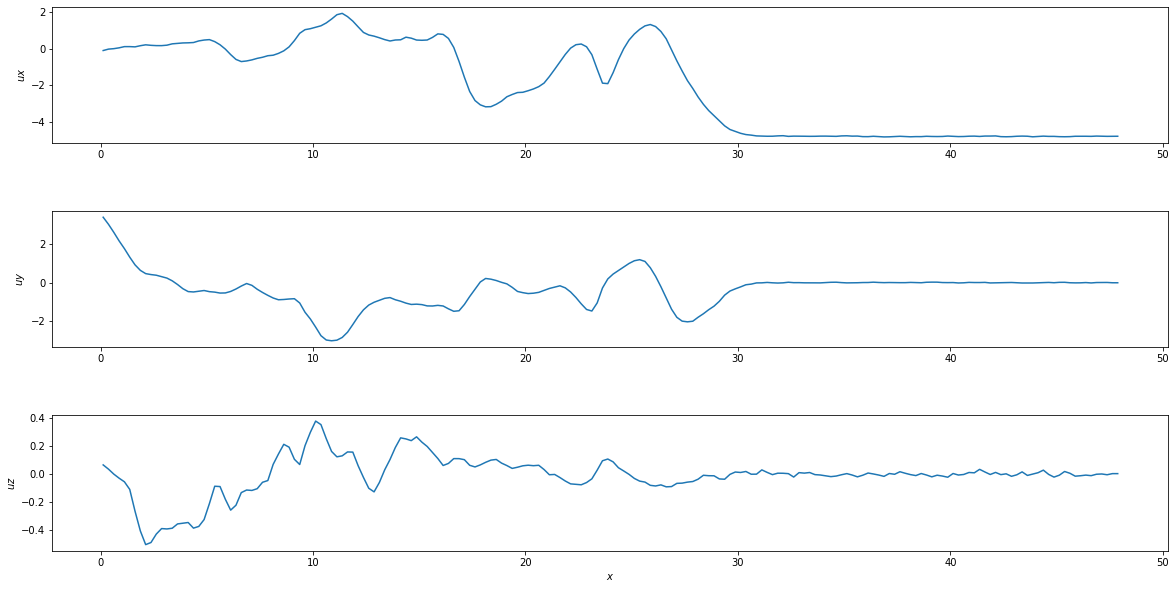

In [6]:
pf.plot_all_flow(dflow, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

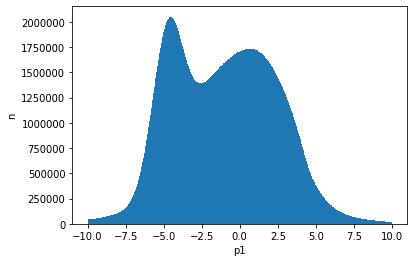

<Figure size 432x288 with 0 Axes>

In [7]:
pf.plot_1d_dist(dparticles, 'p1', 10., dfields['ex_xx'][0], dfields['ex_xx'][-1],dfields['ex_yy'][0], dfields['ex_yy'][-1])

### Compute Shock Vel and Lorentz transform fields

In [8]:
#pick some point in the middle of the simulation and plot it as a function of time
all_dfields = lf.all_dfield_loader(path=path_fields, verbose=False)


In [9]:
vshock, xshockvals = af.shock_from_ex_cross(all_dfields)

Warning, using dt = 0.01 Omega^-1... TODO: automate loading this...


In [ ]:
pf.stack_line_plot(all_dfields,'ex',xshockvals = xshockvals)

In [ ]:
#Lorentz transform fields
dfields = ftf.lorentz_transform_vx(dfields,vx)
_fields = []
for k in range(0,len(all_dfields['dfields'])):
    _fields.append(ftf.lorentz_transform_vx(all_dfields['dfields'][k],vx))
all_dfields['dfields'] = _fields

In [ ]:
pf.plot_all_fields(dfields, axis='_xx', xxindex = 0, yyindex = 0, zzindex = 0)

### Determine where shock is
#### want to figure out the x range of the shock and assign correct metadata values

In [ ]:
#Use this block to determine start and end val
#by editing startval and endval and replotting until bounds are correct
startval = 17.75#lower bound for metadata = 1 (di)
endval = 21.25 #upper bound for metadata = 1 (di)

yyindex = 0
zzindex = 0
pf.plot_field(dfields, 'ex', axis='_xx', yyindex = yyindex, zzindex = zzindex, axvx1 = startval, axvx2 = endval)

In [ ]:
metadata = svf.build_metadata(dfields, startval, endval)

In [ ]:
metadata

### Perform FPC analysis

In [ ]:
#Define parameters related to analysis
vmax = 15.0
dv = 0.25
dx = dfields['ex_xx'][1]-dfields['ex_xx'][0] #assumes rectangular grid thats uniform for all fields

In [ ]:
CEx_out, CEy_out, x_out, Hxy_out, vx_out, vy_out = af.compute_correlation_over_x(dfields, dparticles, vmax, dv, dx, vshock)

### Calculate relevant simulation parameters and save as netcdf4

In [ ]:
inputdict = svf.parse_input_file(path)

In [ ]:
params = svf.build_params(inputdict,numframe)

In [ ]:
inputdict

In [ ]:
params

In [ ]:
flnm = 'dHybridRSDAtest1newformat.nc'
try:
    svf.savedata(CEx_out, CEy_out, vx_out, vy_out, x_out, metadata_out = [], params = params, filename = flnm)
except:
    os.system('rm '+flnm)
    svf.savedata(CEx_out, CEy_out, vx_out, vy_out, x_out, metadata_out = [], params = params, filename = flnm)

### Load netcdf4
#### Saves time if the correlation over x has already been computed

In [ ]:
CEx_in, CEy_in, vx_in, vy_in, x_in, metadata_in, params_in = svf.load_netcdf4(flnm)

In [ ]:
CEx_out[100][60][60]

### Make gif

In [ ]:
pf.make_velsig_gif(vx_in, vy_in, vmax, CEx_out, 'ex', x_out, 'CExframe1000', 'CExframe1000.gif')

<img src="CExframe1000.gif" width="750" align="center">

In [ ]:
pf.make_velsig_gif(vx, vy, vmax, CEy_out, 'ey', x_out, 'CEyframe1000', 'CEyframe1000.gif')

<img src="CEyframe1000.gif" width="750" align="center">

### Perform sanity checks
#### E cross B gif

In [ ]:
pf.make_velsig_gif_with_EcrossB(vx_in, vy_in, vmax, CEx_out, 'ex', x_out, dx, dfields, 'CExFrame1000ExB', 'CExFrame1000ExB.gif')

<img src="CExFrame1000ExB.gif" width="750" align="center">

In [ ]:
pf.make_velsig_gif_with_EcrossB(vx_in, vy_in, vmax, CEy_out, 'ey', x_out, dx, dfields, 'CEyFrame1000ExB', 'CEyFrame1000ExB.gif')

<img src="CEyFrame1000ExB.gif" width="750" align="center">

#### Energization vs J dot E

In [ ]:
import matplotlib.pyplot as plt

JdotEarr = []
energizationCExArr = []
energizationCEyArr = []

xsweep = 0.0
for i in range(0,len(dfields['ex_xx'])):
    JdotEarr.append(sanf.calc_JdotE(dfields ,dflow,xsweep, xsweep+dx, dfields['ey_yy'][0], dfields['ey_yy'][1]))
    
    npar = sanf.getnumparticlesinbox(dparticles, xsweep, xsweep+dx, dfields['ey_yy'][0], dfields['ey_yy'][1])
    
    energizationCExArr.append(af.compute_energization(CEx_out[i],dv)/npar)
    energizationCEyArr.append(af.compute_energization(CEy_out[i],dv)/npar)
    print(xsweep) #'quick progress bar'
    xsweep+=dx


In [ ]:
plt.figure()
plt.plot(x_out,JdotEarr,label='J dot E')
plt.plot(x_out,energizationCExArr,label='E(CEx(x; vy, vx))')
plt.plot(x_out,energizationCEyArr,label='E(CEy(x; vy, vx))')
plt.legend()
plt.show()

In [ ]:
plt.figure()
#plt.plot(x_out,JdotEarr,label='J dot E')
plt.plot(x_out,energizationCExArr,label='E(CEx(x; vy, vx))')
plt.plot(x_out,energizationCEyArr,label='E(CEy(x; vy, vx))')
plt.legend()
plt.show()

##  Plot fields as a function of time

In [ ]:
xxpltpoint = 20.0
xxindex =  af.find_nearest(dfields['ex_xx'], xxpltpoint)
pf.plot_field_time(all_dfields, 'ex', xxindex = xxindex, yyindex = 0, zzindex = 0)

## Test alternative get shock vel

In [ ]:
af.shockvel_from_compression_ratio(3)

In [ ]:
dM = 0.01
M = 1.1
shockvelarray = []
Minputarray = []
for k in range(0,1500):
    shockvelarray.append(af.shockvel_from_compression_ratio(M))
    Minputarray.append(M)
    M += dM
    
plt.figure()
plt.plot(Minputarray,shockvelarray)
plt.show()

In [ ]:
def shock(M):
    gamma = 5./3.
    return lambda v: 8./3.*(M-v)**2./(2./3.*(M-v)**2+2.)-M/v

from scipy.optimize import fsolve
fsolve(shock(3),2.)

In [ ]:
temparr = [1,2,3]
temparr = np.asarray(temparr)
temparr

In [ ]:
temparr += 3

In [ ]:
temparr